In [1]:
%%capture

!pip install imutils
!pip install super_gradients
!pip install albumentations
!pip install split-folders[full]

In [2]:
import os
import math
import random
from typing import Dict, List,Tuple


import numpy as np
import matplotlib.pyplot as plt
import glob
from pathlib import Path, PurePath
import pathlib
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms

from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

from sklearn.model_selection import train_test_split

from imutils import paths

import splitfolders
import textwrap

import super_gradients
from super_gradients.common.object_names import Models
from super_gradients.training import Trainer
from super_gradients.training import training_hyperparams
from super_gradients.training.metrics.classification_metrics import Accuracy, Top5
from super_gradients.training.utils.early_stopping import EarlyStop
from super_gradients.training import models
from super_gradients.training.utils.callbacks import Phase

In [3]:
from pathlib import Path

def count_subdirectories(path: str) -> int:
    """
    Counts the number of subdirectories in the given directory path.
    """
    dir_path = Path(path)
    subdirectories = [f for f in dir_path.iterdir() if f.is_dir()]
    return len(subdirectories)


parent_dir = r"D:\Users\Code\Pycharm\DeepLearning-main\EuroSAT_RGB\EuroSAT_RGB"
n_classes = count_subdirectories(parent_dir)
n_classes

10

In [4]:
class config:

    DOWNLOAD_DIR = Path(r'D:\Users\Code\Pycharm\DeepLearning-main\EuroSAT_RGB\EuroSAT_RGB')
    ROOT_DIR = Path('content')
    TRAIN_DIR = ROOT_DIR.joinpath('train')
    TEST_DIR = ROOT_DIR.joinpath('test')
    VAL_DIR = ROOT_DIR.joinpath('val')


    INPUT_HEIGHT = 64
    INPUT_WIDTH = 64

    
    EUROSAT_MEAN = [0.491, 0.482, 0.446]
    EUROSAT_STD = [0.247, 0.243, 0.261]

    IMAGE_TYPE = '.jpg'
    BATCH_SIZE = 128
    MODEL_NAME = 'vit_base'
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
    TRAINING_PARAMS = 'training_hyperparams/imagenet_vit_train_params'

    NUM_CLASSES = n_classes
    CHECKPOINT_DIR = 'checkpoints'

In [5]:
splitfolders.ratio(config.DOWNLOAD_DIR, output=config.ROOT_DIR, seed=42, ratio=(.8, .1, .1), group_prefix=None, move=False)

Copying files: 26498 files [00:15, 1962.43 files/s]

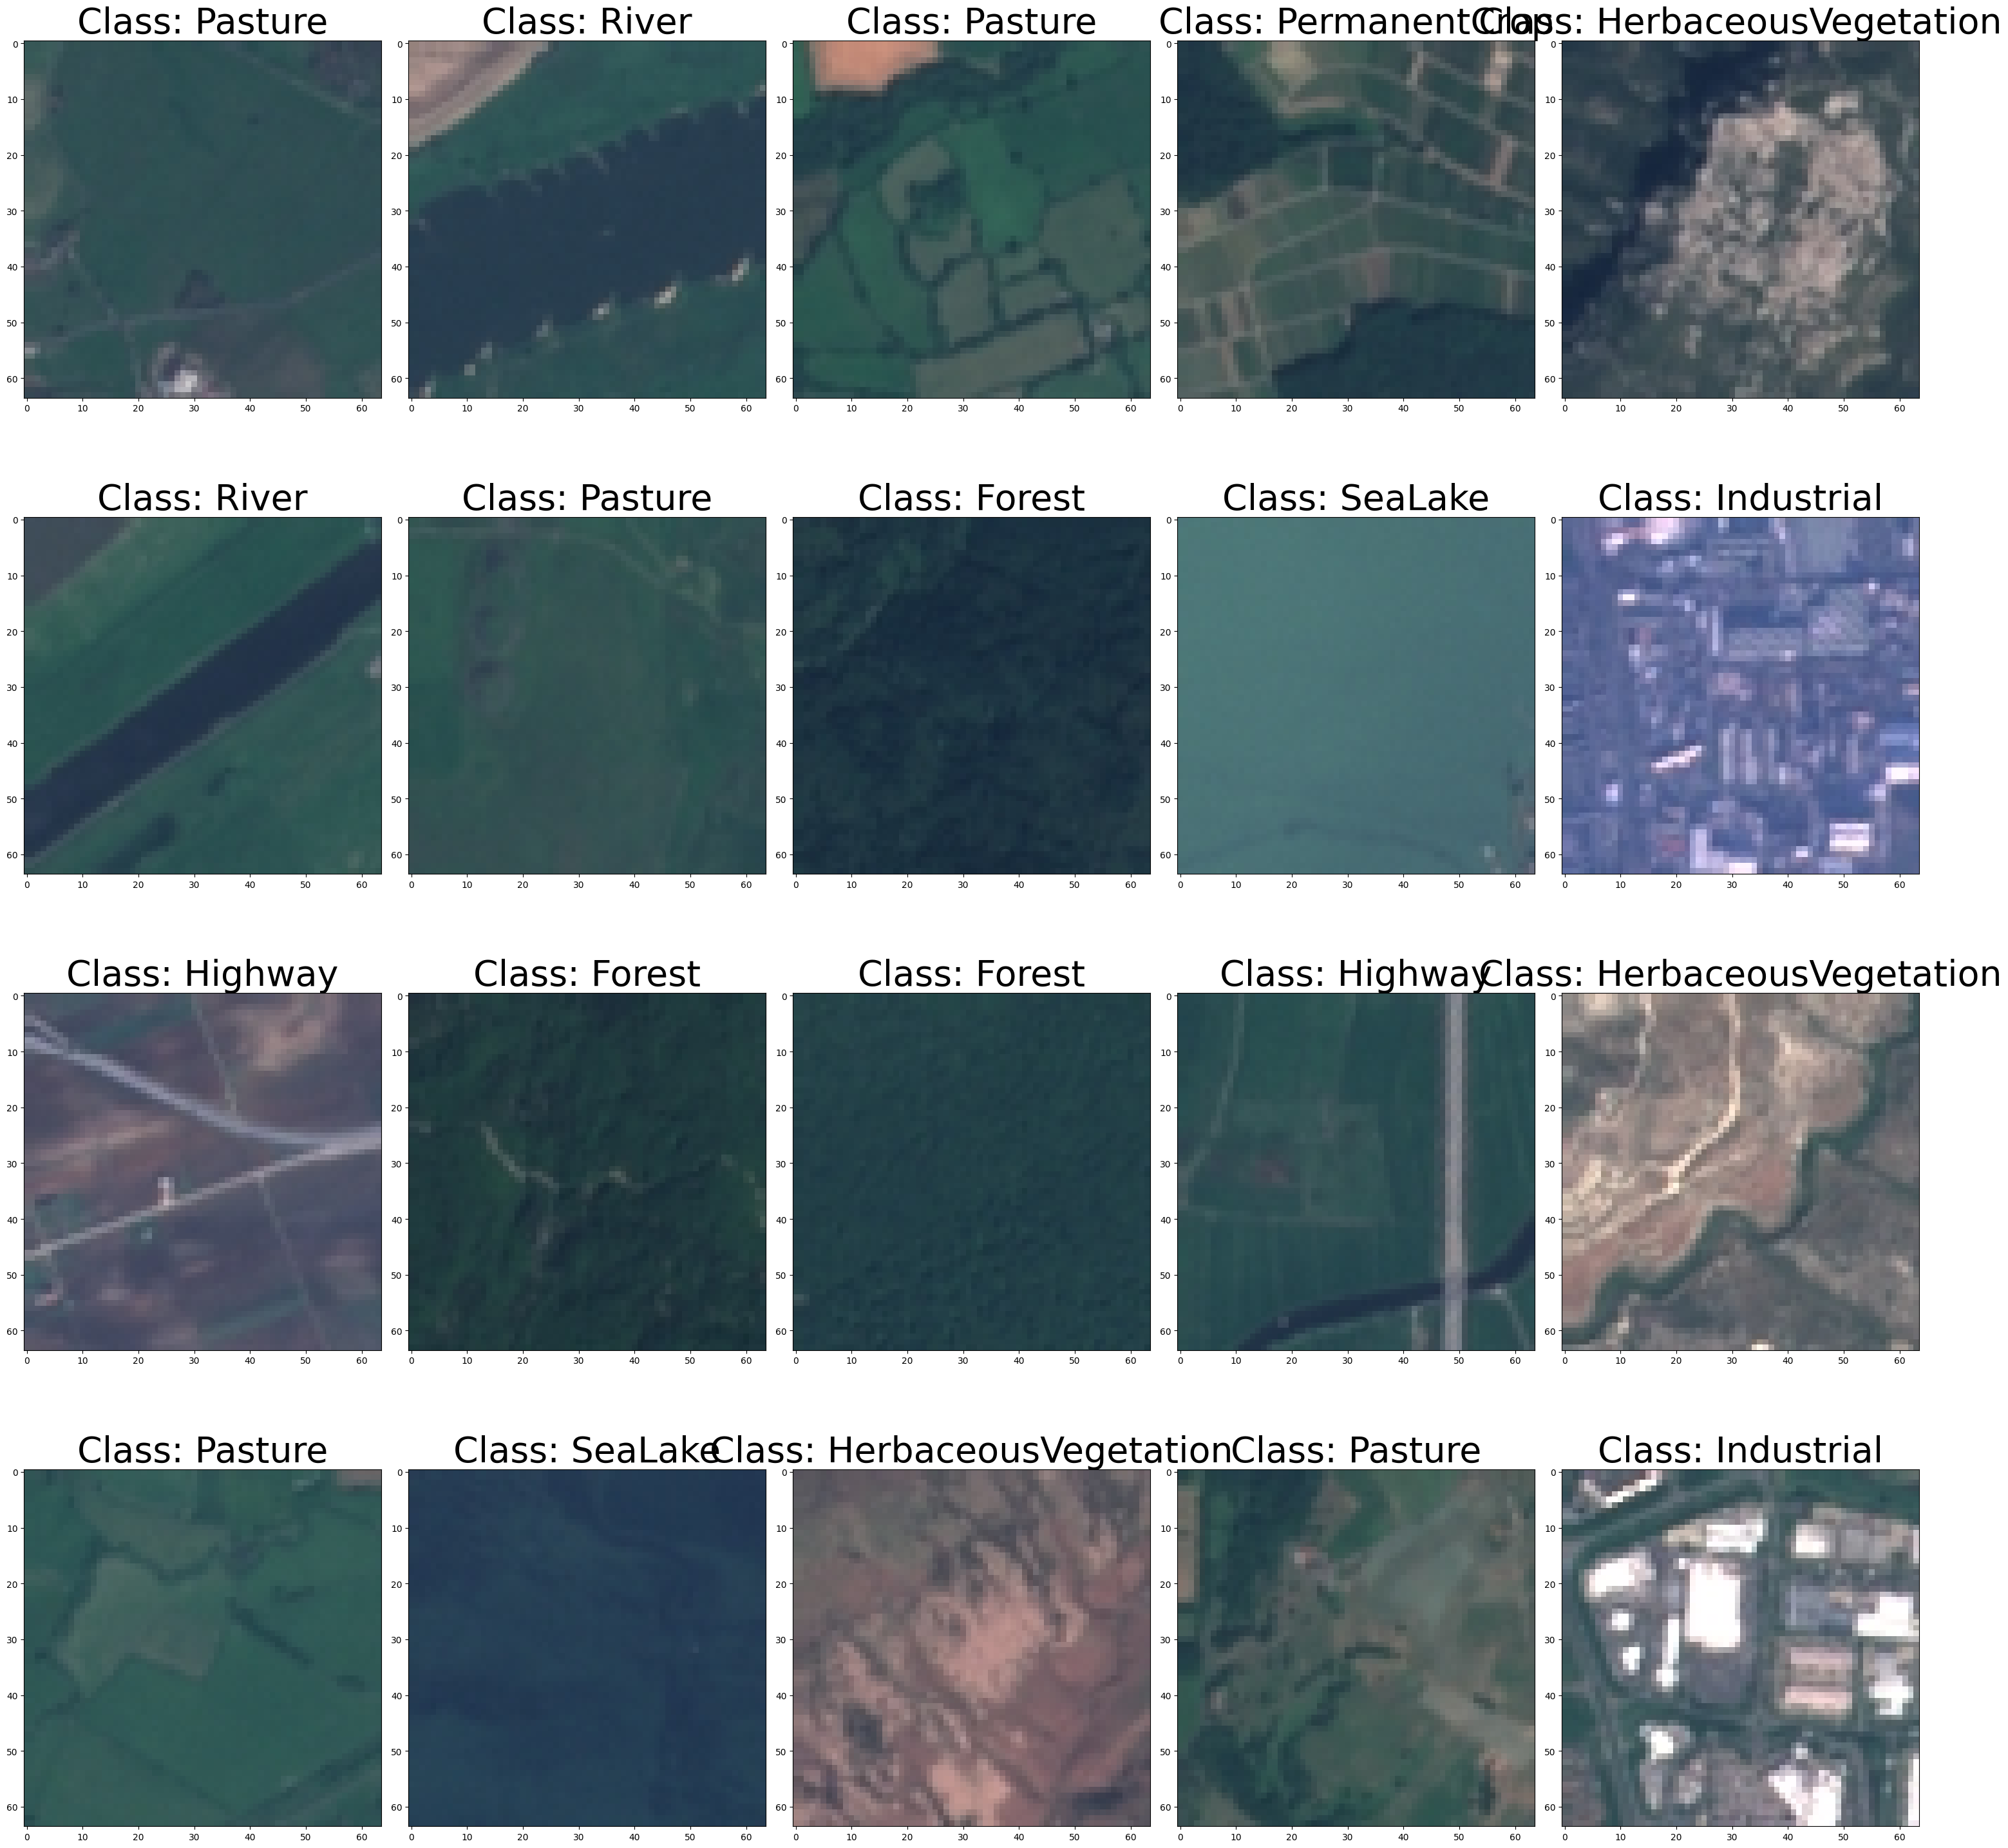

In [6]:
train_image_path_list = list(sorted(paths.list_images(config.TRAIN_DIR)))
train_image_path_sample = random.sample(population=train_image_path_list, k=20)


def examine_images(images: list):
    num_images = len(images)
    num_rows = int(math.ceil(num_images / 5))
    num_cols = 5

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 30), tight_layout=True)
    axs = axs.ravel()

    for i, image_path in enumerate(images[:num_images]):
        image = Image.open(image_path)
        label = PurePath(image_path).parent.name
        axs[i].imshow(image)
        axs[i].set_title(f"Class: {label}", fontsize=40)
        
    plt.show()


examine_images(train_image_path_sample)

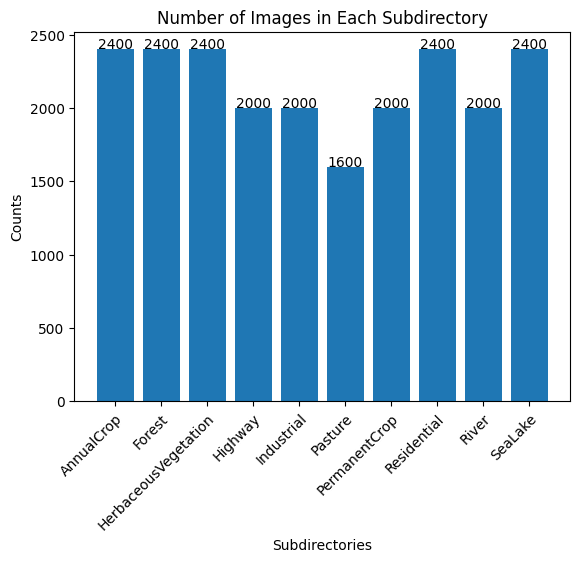

In [7]:
subdirs = [d for d in Path(config.TRAIN_DIR).iterdir() if d.is_dir()]

image_count = {}


for subdir in subdirs:
    subdir_images = list(sorted(paths.list_images(subdir)))
    image_count[subdir.name] = len(subdir_images)

plt.bar(image_count.keys(), image_count.values())

for i, (subdir, count) in enumerate(image_count.items()):
    plt.text(i, count + 3, str(count), ha='center')

plt.xticks( rotation=45, ha="right", rotation_mode="anchor")
plt.title("Number of Images in Each Subdirectory")
plt.xlabel("Subdirectories")
plt.ylabel("Counts")


plt.show()

In [8]:
image_types = {'path': [], 'mode': []}

for file_path in paths.list_images(config.ROOT_DIR):

    with Image.open(file_path) as img:
        image_types['path'].append(file_path)
        image_types['mode'].append(img.mode)


image_types_df = pd.DataFrame(image_types)
image_types_df['class'] = image_types_df['path'].apply(lambda x: Path(x).parent.name)

In [9]:
image_types_df['mode'].value_counts()

mode
RGB    27000
Name: count, dtype: int64

In [10]:
image_types_df.groupby('class')['mode'].value_counts()

class                 mode
AnnualCrop            RGB     3000
Forest                RGB     3000
HerbaceousVegetation  RGB     3000
Highway               RGB     2500
Industrial            RGB     2500
Pasture               RGB     2000
PermanentCrop         RGB     2500
Residential           RGB     3000
River                 RGB     2500
SeaLake               RGB     3000
Name: count, dtype: int64

In [11]:
resize = transforms.Resize(size=(config.INPUT_HEIGHT,config.INPUT_WIDTH))
make_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=config.EUROSAT_MEAN, std=config.EUROSAT_STD)
center_cropper = transforms.CenterCrop((config.INPUT_HEIGHT,config.INPUT_WIDTH))
random_horizontal_flip = transforms.RandomHorizontalFlip(p=0.75)
random_vertical_flip = transforms.RandomVerticalFlip(p=0.75)
random_rotation = transforms.RandomRotation(degrees=90)
random_crop = transforms.RandomCrop(size=(200,200))
augmix = transforms.AugMix(severity = 3, mixture_width=3, alpha=0.2)
auto_augment = transforms.AutoAugment()
random_augment = transforms.RandAugment()


train_transforms = transforms.Compose([
  resize,
  auto_augment,
  augmix,
  random_augment,
  make_tensor,
  normalize
])

val_transforms = transforms.Compose([resize, make_tensor, normalize])

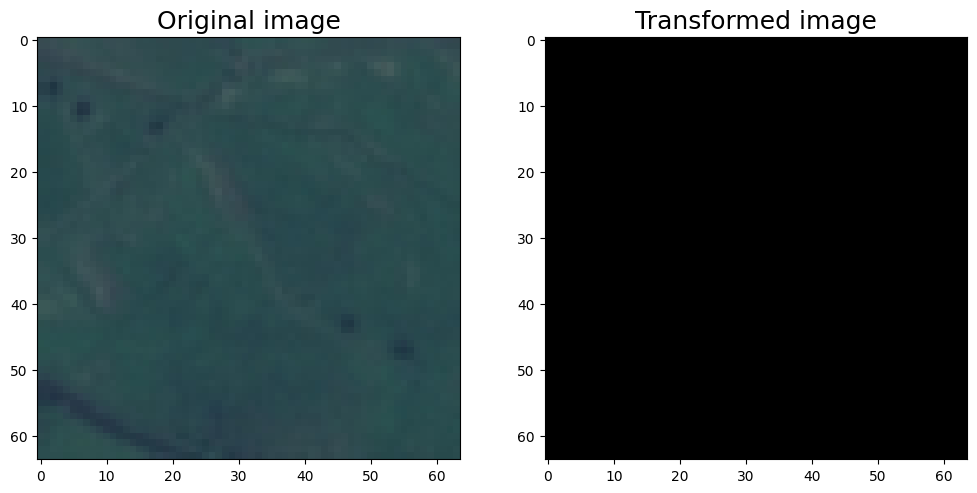

In [12]:
def apply_transform(img: Image, transform) -> np.ndarray:
    """
    Applies a transform to a PIL Image and returns a numpy array of the transformed image.

    Args:
        img (PIL.Image): The input image to transform.
        transform (torchvision.transforms.Compose): The transform to apply to the image.

    Returns:
        np.ndarray: A numpy array representing the transformed image.
    """

    if isinstance(transform, torchvision.transforms.Compose):
     
        transformed_image = train_transforms(img)

    elif isinstance(transform, A.Compose):
       
        img_array = np.array(img)
        transformed_image = transform(image=img_array)["image"]

    img_array = transformed_image.numpy().transpose((1, 2, 0))

   
    img_array = np.clip(img_array, 0, 1)

    return img_array


def visualize_transform(image: np.ndarray, original_image: np.ndarray = None) -> None:
    """
    Visualize the transformed image.

    Args:
        image (np.ndarray): A NumPy array representing the transformed image.
        original_image (np.ndarray, optional): A NumPy array representing the original image. Defaults to None.
    """
    fontsize = 18

    if original_image is None:
       
        f, ax = plt.subplots(1, 2, figsize=(12, 12))

     
        ax[0].imshow(image)
    else:
     
        f, ax = plt.subplots(1, 2, figsize=(12, 12))


        ax[0].imshow(original_image)
        ax[0].set_title('Original image', fontsize=fontsize)


        ax[1].imshow(image)
        ax[1].set_title('Transformed image', fontsize=fontsize)



img = Image.open(random.choice(train_image_path_list))
img_array = apply_transform(img, train_transforms)
visualize_transform(img_array, original_image=img)

In [13]:
def create_dataloaders(
    train_dir: str,
    val_dir: str,
    test_dir: str,
    train_transform: transforms.Compose,
    val_transform:  transforms.Compose,
    test_transform:  transforms.Compose,
    batch_size: int,
    num_workers: int=2
):
  """Creates training and validation DataLoaders.
  Args:
    train_dir: Path to training data.
    val_dir: Path to validation data.
    transform: Transformation pipeline.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.
  Returns:
    A tuple of (train_dataloader, val_dataloader, class_names).
  """
  
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  val_data = datasets.ImageFolder(val_dir, transform=val_transform)
  test_data = datasets.ImageFolder(test_dir, transform=val_transform)

  print(f"[INFO] training dataset contains {len(train_data)} samples...")
  print(f"[INFO] validation dataset contains {len(val_data)} samples...")
  print(f"[INFO] test dataset contains {len(test_data)} samples...")


  class_names = train_data.classes
  print(f"[INFO] dataset contains {len(class_names)} labels...")


  print("[INFO] creating training and validation set dataloaders...")
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      drop_last=True,
      num_workers=num_workers,
      pin_memory=True,
      persistent_workers=True
  )
  val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
      drop_last=False,
      persistent_workers=True
  )

  return train_dataloader, val_dataloader, test_dataloader, class_names

In [14]:
train_dataloader, valid_dataloader, test_dataloader, class_names = create_dataloaders(train_dir=config.TRAIN_DIR,
                                                                     val_dir=config.VAL_DIR,
                                                                     test_dir=config.TEST_DIR,
                                                                     train_transform=train_transforms,
                                                                     val_transform=val_transforms,
                                                                     test_transform=val_transforms,
                                                                     batch_size=config.BATCH_SIZE)

NUM_CLASSES = len(class_names)

In [15]:
training_params =  training_hyperparams.get(config.TRAINING_PARAMS)

In [16]:
early_stop_acc = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="Accuracy", mode="max", patience=7, verbose=True)
early_stop_val_loss = EarlyStop(Phase.VALIDATION_EPOCH_END, monitor="CrossEntropyLoss", mode="min", patience=7, verbose=True)

training_params["train_metrics_list"] = [Accuracy()]
training_params["valid_metrics_list"] = [Accuracy()]
training_params["phase_callbacks"] = [early_stop_acc, early_stop_val_loss]


training_params["silent_mode"] = False
training_params["optimizer"] = 'AdamW'
training_params['optimizer_params'] = {}
training_params['average_best_models'] = True
training_params['ema']= True
training_params["criterion_params"] = {'smooth_eps': 0.30}
training_params["max_epochs"] = 100
training_params["initial_lr"] = 0.0001

In [17]:
model = models.get(config.MODEL_NAME, num_classes = config.NUM_CLASSES, pretrained_weights='imagenet')

In [18]:
full_model_trainer = Trainer(experiment_name='0_Baseline_Experiment', ckpt_root_dir=config.CHECKPOINT_DIR)

In [19]:
full_model_trainer.train(model=model,
              training_params=training_params,
              train_loader=train_dataloader,
              valid_loader=valid_dataloader)

Validating epoch 100: 100%|██████████| 22/22 [00:01<00:00, 12.27it/s]


In [20]:
best_full_model = models.get(config.MODEL_NAME,
                        num_classes=config.NUM_CLASSES,
                        checkpoint_path=os.path.join(full_model_trainer.checkpoints_dir_path, "average_model.pth"))

In [21]:
full_model_trainer.test(model=best_full_model,
            test_loader=test_dataloader,
            test_metrics_list=['Accuracy'])

Testing:  86%|████████▋ | 19/22 [00:06<00:00,  9.41it/s]

{'CrossEntropyLoss': 1.2066528, 'Accuracy': 0.9814814925193787}

In [22]:
import requests
def pred_and_plot_image(image_path: str,
                        subplot: Tuple[int, int, int],  
                        class_names: List[str] = class_names,
                        model: torch.nn.Module = best_full_model,
                        image_size: Tuple[int, int] = (config.INPUT_HEIGHT, config.INPUT_WIDTH),
                        transform: torchvision.transforms = None,
                        device: torch.device=config.DEVICE):

    if isinstance(image_path, pathlib.PosixPath):
      img = Image.open(image_path)
    else:
      img = Image.open(requests.get(image_path, stream=True).raw)

    
    if transform is None:
        transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=config.EUROSAT_MEAN,
                                 std=config.EUROSAT_STD),
        ])
    transformed_image = transform(img)

   
    model.to(device)

    
    model.eval()
    with torch.inference_mode():
       
        transformed_image = transformed_image.unsqueeze(dim=0)

      
        target_image_pred = model(transformed_image.to(device))


    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

  
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)


    ground_truth = PurePath(image_path).parent.name

 
    plt.subplot(*subplot)
    plt.imshow(img)
    if isinstance(image_path, pathlib.PosixPath):
        title = f"Ground Truth: {ground_truth} | Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    else:
        title = f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}"
    plt.title("\n".join(textwrap.wrap(title, width=20)))  
    plt.axis(False)


def plot_random_test_images(model):
    num_images_to_plot = 30
    test_image_path_list = [pathlib.PosixPath(p) for p in sorted(paths.list_images(config.TEST_DIR))] 
    test_image_path_sample = random.sample(population=test_image_path_list,
                                           k=num_images_to_plot)


    num_rows = int(np.ceil(num_images_to_plot / 5))
    fig, ax = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))
    ax = ax.flatten()


    for i, image_path in enumerate(test_image_path_sample):
        pred_and_plot_image(model=model,
                            image_path=image_path,
                            class_names=class_names,
                            subplot=(num_rows, 5, i+1),
                            image_size=(config.INPUT_HEIGHT, config.INPUT_WIDTH))


    plt.subplots_adjust(wspace=1)
    plt.show()

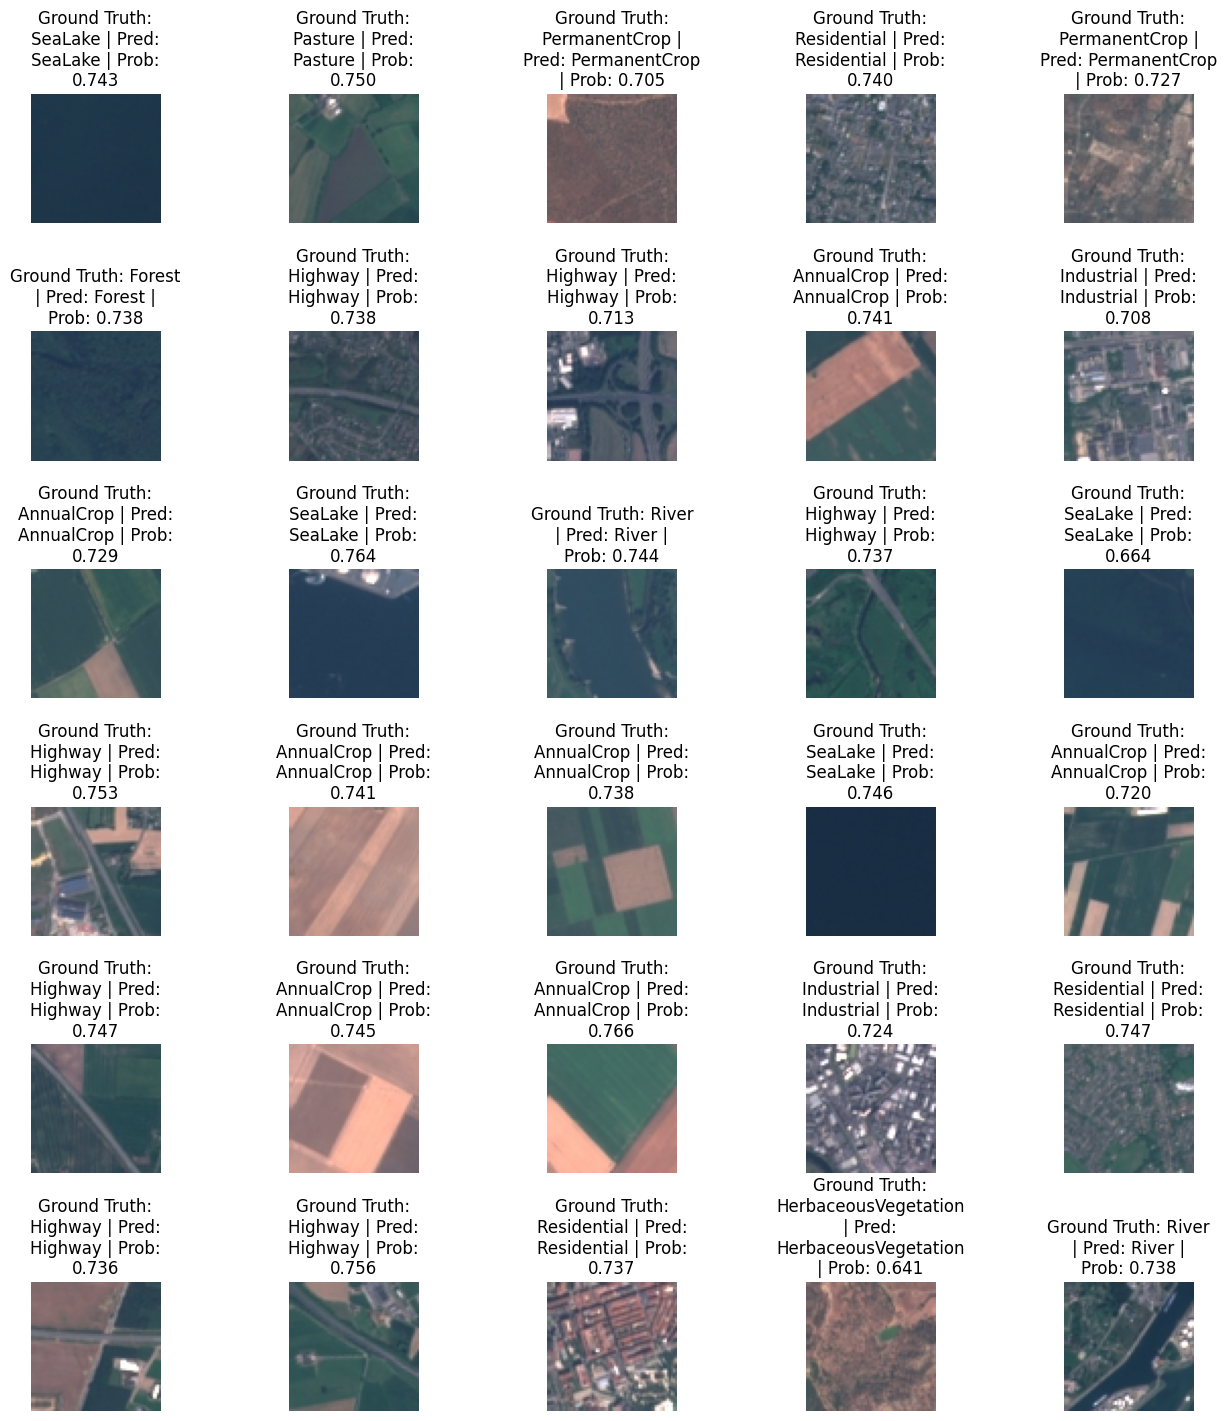

In [23]:
import pathlib
temp = pathlib.PosixPath
pathlib.PosixPath = pathlib.WindowsPath
plot_random_test_images(best_full_model)

In [24]:
pathlib.PosixPath = temp

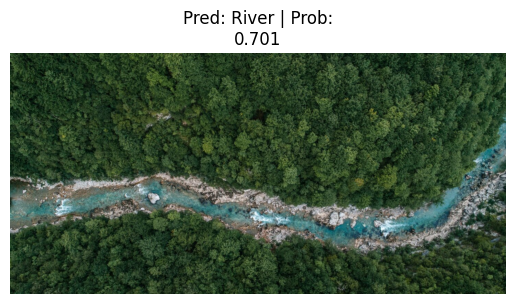

In [25]:
image_url = 'https://erepublic.brightspotcdn.com/dims4/default/570a482/2147483647/strip/true/crop/946x460+0+85/resize/1440x700!/quality/90/?url=http%3A%2F%2Ferepublic-brightspot.s3.us-west-2.amazonaws.com%2Fed%2Fbd%2F1aa3bb97386362850dce229b2a87%2Fshutterstock-700197307.jpg'
pred_and_plot_image(image_path= image_url, subplot=(1, 1, 1))

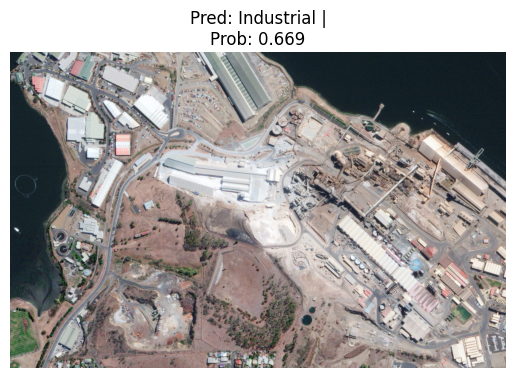

In [26]:
image_url = 'https://wp-cdn.apollomapping.com/web_assets/user_uploads/2020/08/06152603/hobart_factory_ge1_50cm-scaled.jpg'
pred_and_plot_image(image_path= image_url, subplot=(1, 1, 1))

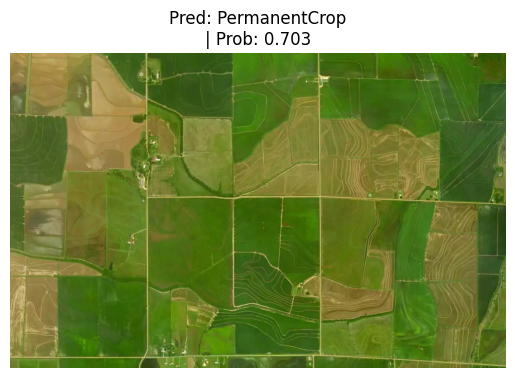

In [27]:
image_url = 'https://www.planetwatchers.com/wp-content/uploads/2023/04/Satellite-view-of-farmland-in-Iowa-USA-for-acreage-report-e1685004471423-copy-compress.webp'
pred_and_plot_image(image_path= image_url, subplot=(1, 1, 1))

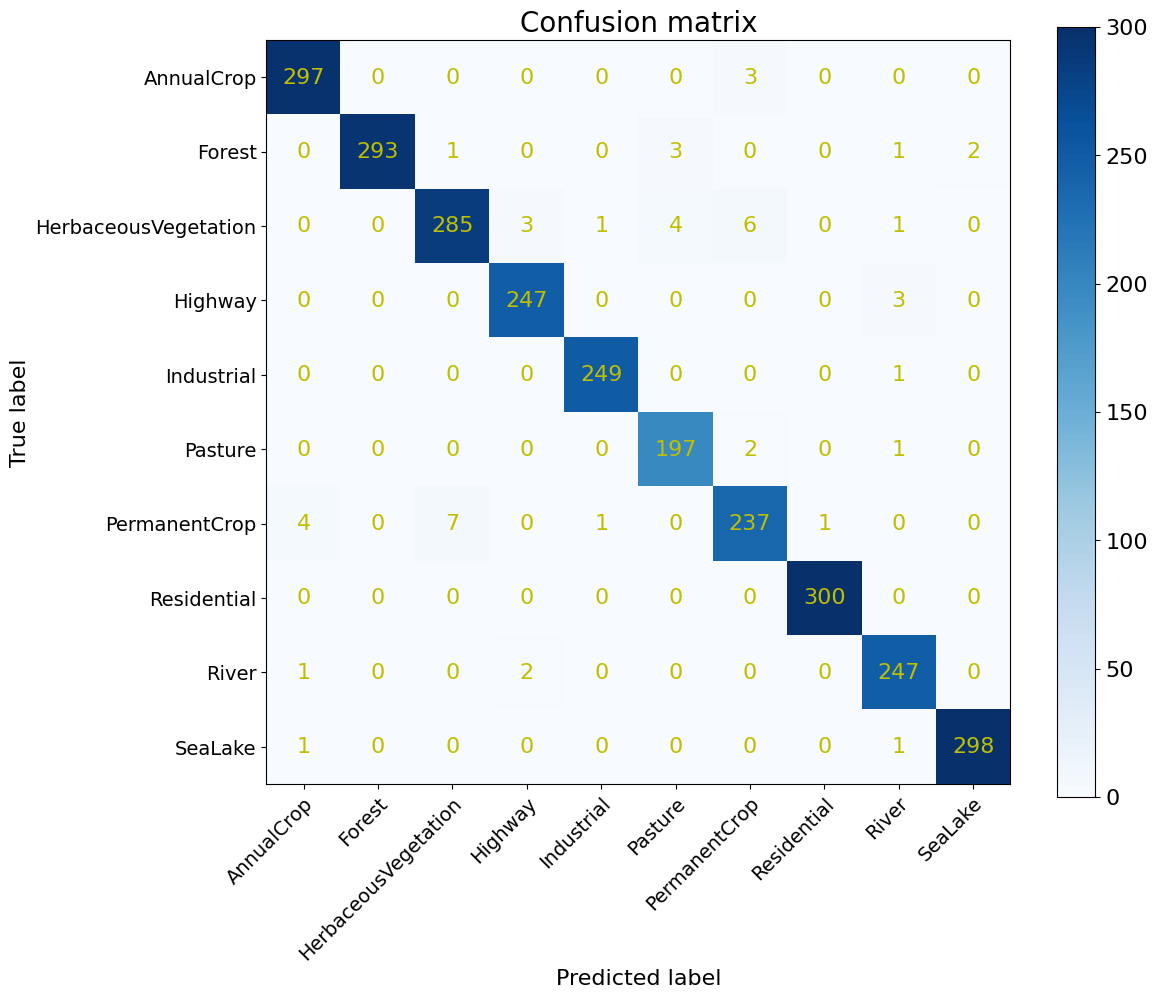

In [28]:
from sklearn.metrics import confusion_matrix


best_full_model.eval()


true_labels = []
predicted_labels = []


for images, labels in test_dataloader:
    images = images.to(config.DEVICE)
    labels = labels.to(config.DEVICE)
    with torch.no_grad():
        outputs = best_full_model(images)
        _, predicted = torch.max(outputs.data, 1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())


conf_matrix = confusion_matrix(true_labels, predicted_labels)


fig, ax = plt.subplots(figsize=(12, 10))
plt.rcParams.update({'font.size': 16})


im = ax.imshow(conf_matrix, cmap='Blues')


cbar = ax.figure.colorbar(im, ax=ax)


ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, fontsize=14)
ax.set_yticklabels(class_names, fontsize=14)
ax.set_xlabel('Predicted label', fontsize=16)
ax.set_ylabel('True label', fontsize=16)


plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")


for i in range(len(class_names)):
    for j in range(len(class_names)):
        if conf_matrix[i, j] >= -1: 
            text = ax.text(j, i, conf_matrix[i, j],
                           ha="center", va="center", color="y", fontsize=16)
        else:
            text = ax.text(j, i, "",
                           ha="center", va="center", color="y")


ax.set_title("Confusion matrix", fontsize=20)


plt.show()